In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
os.listdir("/content/gdrive/MyDrive/archive-3")

['test', 'train', 'data']

In [5]:
os.listdir("/content/gdrive/MyDrive/archive-3/train")

['benign', 'malignant']

In [6]:
ben_dir = "/content/gdrive/MyDrive/archive-3/train/benign"
malig_dir = "/content/gdrive/MyDrive/archive-3/train/malignant"

train_dir = "/content/gdrive/MyDrive/archive-3/train"
test_dir = "/content/gdrive/MyDrive/archive-3/test"

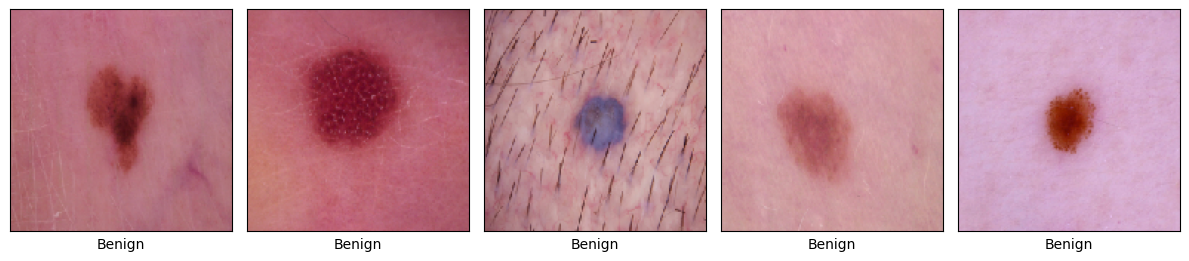

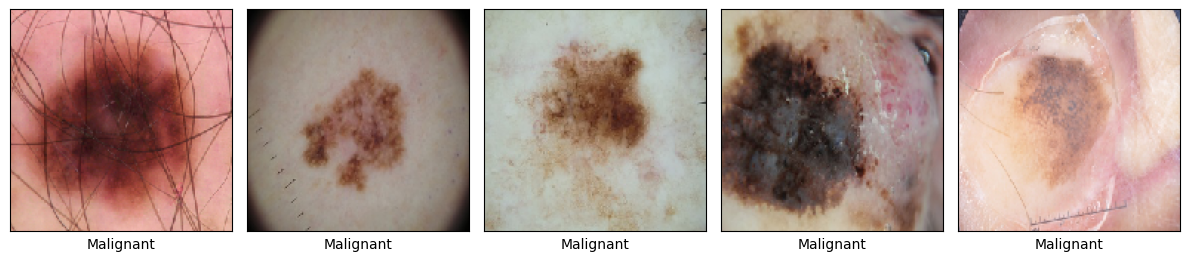

In [7]:
import random

from tensorflow.keras.preprocessing.image import load_img
plt.figure(figsize=(12,7))
ben = random.sample(os.listdir(ben_dir),5)
malig = random.sample(os.listdir(malig_dir),5)

for i,img in enumerate(ben):
    path = os.path.join(ben_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Benign")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

plt.figure(figsize=(12,7))
for i,img in enumerate(malig):
    path = os.path.join(malig_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Malignant")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale =(1./255),rotation_range=0.2,
    width_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest',
    horizontal_flip= True)

val_datagen = ImageDataGenerator(rescale =(1./255))

train_data = train_datagen.flow_from_directory(directory = train_dir, 
                                               target_size =(224,224),
                                               class_mode = "binary",
                                               batch_size =32)
test_data = val_datagen.flow_from_directory(directory = test_dir, 
                                               target_size =(224,224),
                                               class_mode = "binary",
                                               batch_size =32)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


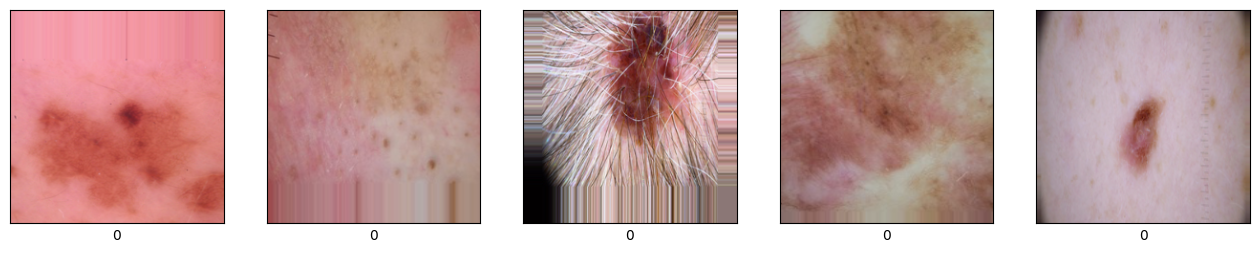

In [9]:
from tensorflow.keras.preprocessing import image
sample_x, sample_y = next(train_data)
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = image.img_to_array(sample_x[i])
    plt.imshow(img)
    plt.xlabel(np.argmax(sample_y[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [10]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))

29084464/29084464 [==============================] - 2s 0us/step


In [11]:
for layer in dense.layers[:121]:
    layer.trainable = False

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization 

model = Sequential()
model.add(dense)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512,activation= "sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 1024)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 3, 3, 1024)       4096      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4719104   
                                                                 
 dropout_4 (Dropout)         (None, 512)              

In [14]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.2 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [33]:

import tensorflow_addons as tfa
from tensorflow.keras import metrics
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
metrics = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall'),
           F1Score(num_classes = 1,name = 'f1'),
           MatthewsCorrelationCoefficient(num_classes = 1,name='mc'),
           tf.keras.metrics.TruePositives(name= 'tp'),
           tf.keras.metrics.TrueNegatives(name = 'tn'),
           tf.keras.metrics.FalseNegatives(name = 'fn'),
           tf.keras.metrics.FalsePositives(name = 'fp')
          ]

lr=0.0001
model.compile(optimizer = Adam(lr = 0.0001), loss = "binary_crossentropy", metrics = metrics)

In [35]:
patience = 1
stop_patience = 3
factor = 0.3

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [17]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [36]:
history = model.fit(train_data, validation_data = test_data, epochs =15, 
                    verbose = 1, callbacks = callbacks )

Epoch 1/15
83/83 [==============================] - 116s 676ms/step - loss: 0.3335 - accuracy: 0.8650 - precision: 0.8461 - recall: 0.8588 - f1: 0.6244 - mc: 0.0000e+00 - tp: 1028.0000 - tn: 1253.0000 - fn: 169.0000 - fp: 187.0000 - val_loss: 0.4635 - val_accuracy: 0.8333 - val_precision: 0.7762 - val_recall: 0.8900 - val_f1: 0.6250 - val_mc: 0.0000e+00 - val_tp: 267.0000 - val_tn: 283.0000 - val_fn: 33.0000 - val_fp: 77.0000 - lr: 0.0010
Epoch 2/15
83/83 [==============================] - 48s 578ms/step - loss: 0.2410 - accuracy: 0.8931 - precision: 0.8778 - recall: 0.8881 - f1: 0.6244 - mc: 0.0000e+00 - tp: 1063.0000 - tn: 1292.0000 - fn: 134.0000 - fp: 148.0000 - val_loss: 0.2453 - val_accuracy: 0.9076 - val_precision: 0.9509 - val_recall: 0.8400 - val_f1: 0.6250 - val_mc: 0.0000e+00 - val_tp: 252.0000 - val_tn: 347.0000 - val_fn: 48.0000 - val_fp: 13.0000 - lr: 0.0010
Epoch 3/15
83/83 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9177 - precision: 0.9036 -

In [37]:

model.evaluate(test_data)

21/21 [==============================] - 3s 145ms/step - loss: 0.2222 - accuracy: 0.9333 - precision: 0.9238 - recall: 0.9300 - f1: 0.6250 - mc: 0.0000e+00 - tp: 279.0000 - tn: 337.0000 - fn: 21.0000 - fp: 23.0000


[0.22221826016902924,
 0.9333333373069763,
 0.9238410592079163,
 0.9300000071525574,
 array([0.625], dtype=float32),
 0.0,
 279.0,
 337.0,
 21.0,
 23.0]

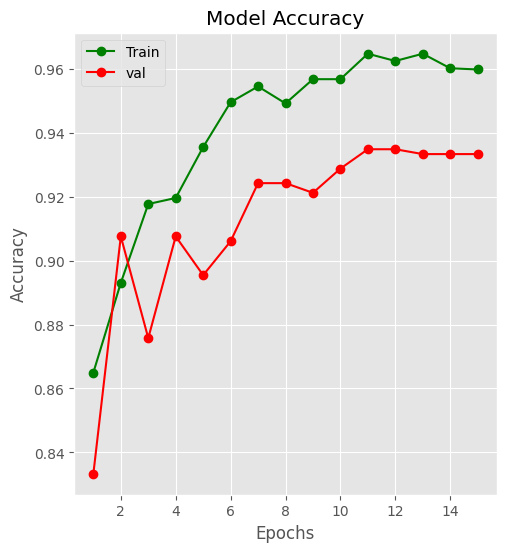

In [38]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")
#plt.show()



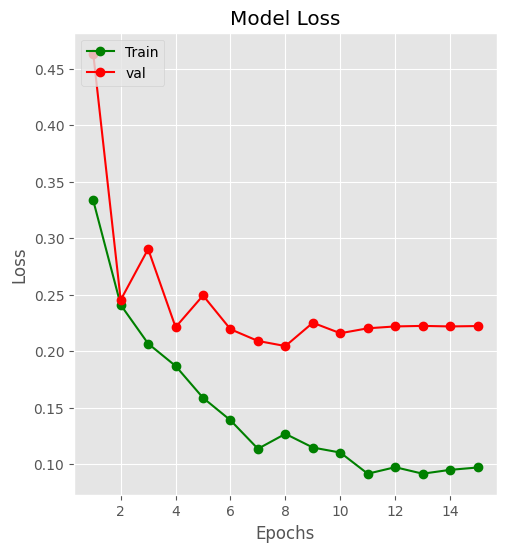

In [39]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

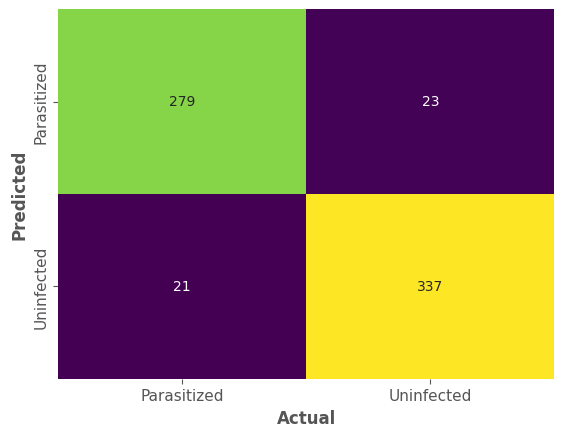

In [40]:
import seaborn as sns
cm_data = [[history.history['val_tp'][-1], history.history['val_fp'][-1]], [history.history['val_fn'][-1], history.history['val_tn'][-1]]]
sns.heatmap(cm_data, annot=True, cmap = 'viridis',cbar = False,fmt = 'g')
plt.xticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.yticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.xlabel("Actual",fontsize=12, fontweight="bold")
plt.ylabel("Predicted",fontsize=12, fontweight="bold")
plt.show()